# Spatial distribution of lakes

In [47]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [48]:
# out_path_csv = '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/GLD1_all_lakes.csv'
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais.csv'
# out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_all_returned_lakes.csv'
df = pd.read_csv(out_path_csv)

In [49]:
df_lakes = df.copy()
# df_lakes = df[((df.quality_summary > 0) 
#                & (df.surface_elevation > 1.0) 
#                & (df.max_depth < 50) 
#                & (df.max_depth > 0.5))].copy()
# df_lakes = df.copy()
# df_lakes.sort_values(by='quality_summary', ascending=False, inplace=True)
# len(df_lakes)

# df_lakes = df_lakes[df_lakes.quality_summary > 0.01]
# len(df_lakes)

In [50]:
sz_sup = 14
sz_tit_l = 12
sz_tit_s = 7
sz_lab_l = 10
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

In [51]:
fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = '../GlacierLakeDetectionICESat2/basins/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = '../GlacierLakeDetectionICESat2/basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = '../GlacierLakeDetectionICESat2/basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_merged.shp'
fn_thresh = '../GlacierLakeDetectionICESat2/basins/shapefiles/ANT_basins_thresh1000.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = '../GlacierLakeDetectionICESat2/basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = '../GlacierLakeDetectionICESat2/basins/shapefiles/GRE_basins_merged.shp'
fn_thresh = '../GlacierLakeDetectionICESat2/basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)

In [52]:
gdf_lakes = gpd.GeoDataFrame(df_lakes, geometry=gpd.points_from_xy(df_lakes.lon, df_lakes.lat), crs="EPSG:4326")
gdf_ant = gdf_lakes[gdf_lakes.ice_sheet=='AIS'].to_crs(ant_gdf_basin.crs)
gdf_gre = gdf_lakes[gdf_lakes.ice_sheet=='GrIS'].to_crs(gre_gdf_basin.crs)
for gdf in [gdf_ant, gdf_gre]:
    gdf['x'] = gdf.apply(lambda x: x.geometry.x, axis=1)
    gdf['y'] = gdf.apply(lambda x: x.geometry.y, axis=1)

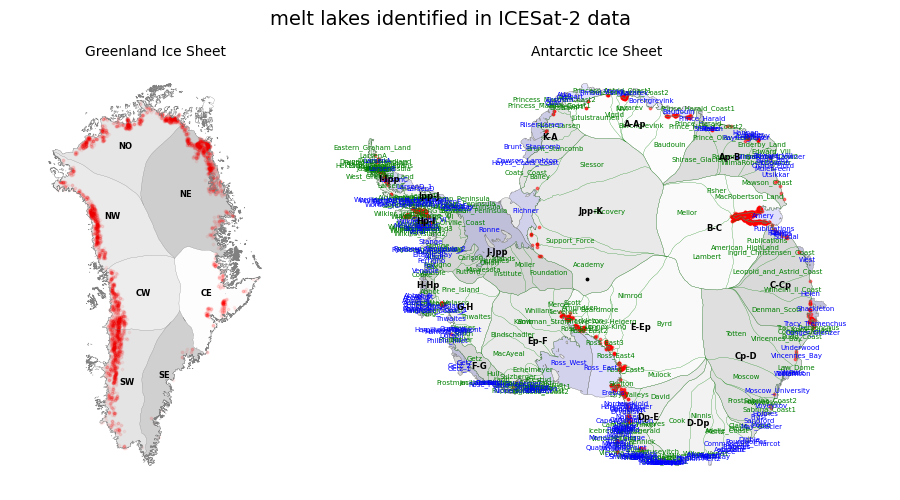

In [53]:
from matplotlib import colormaps as cm
plt.close('all')
fig = plt.figure(figsize=[9,5])
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Antarctica
ax = ax2
ant_gdf_merged.plot(column='Subregions', cmap=cmc.grayCS, alpha=0.2, ax=ax)
ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.1)
ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0.1)
ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2)
# ant_gdf_thresh.exterior.plot(color='green', ax=ax, lw=0.1)
ant_gdf_basin.dissolve().boundary.plot(color='gray', ax=ax, lw=0.2)
gdf_ant.sort_values(by='quality_summary', inplace=True)

# ant_gdf_basin.boundary.plot(color='g', ax=ax, lw=0.1)
ant_gdf_basin.exterior.plot(color='green', ax=ax, lw=0.1)
ant_gdf_basin.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='g',fontsize=5),axis=1)
ant_gdf_shelf.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center',va='center',color='b',fontsize=5),axis=1)


# ax.scatter(gdf_ant.x, gdf_ant.y, s=3, alpha=np.clip(gdf_ant.quality_summary**(1/5),0,1), 
#            c=np.clip(gdf_ant.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=0, vmax=1.66)
# ax.scatter(gdf_ant.x, gdf_ant.y, s=3, alpha=1, 
#            c=np.clip(gdf_ant.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=-0.3, vmax=1.6)
ax.scatter(gdf_ant.x, gdf_ant.y, s=3, c='r', alpha=0.5)

ax.scatter(0,0,s=3,color='k')
# def add_shelf_label(shelf, min_area=1e10):
#     if shelf.geometry.area > min_area: 
#         ax.annotate(text=shelf['NAME'], xy=shelf.geometry.centroid.coords[0], ha='center',va='center',
#                                        color='b',fontsize=4)
# ant_gdf_shelf.reset_index().apply(add_shelf_label, axis=1);

ant_gdf_merged.apply(lambda x: ax.annotate(text=x['Subregions'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6, weight='bold'),axis=1);
ax.set_title('Antarctic Ice Sheet', fontsize=10)
ax.axis('off')

# Greenland
ax = ax1
gre_gdf_merged.plot(column='SUBREGION1', cmap=cmc.grayCS, alpha=0.2, ax=ax)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.1)
# gre_gdf_thresh.exterior.plot(color='green', ax=ax, lw=0.1)
gre_gdf_basin.dissolve().boundary.plot(color='gray', ax=ax, lw=0.2)
gdf_gre.sort_values(by='quality_summary', inplace=True)

ax.scatter(gdf_gre.x, gdf_gre.y, s=3, c='r', alpha=0.05)
# ax.scatter(gdf_gre.x, gdf_gre.y, s=3, alpha=1, 
#            c=np.clip(gdf_gre.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=0, vmax=1.66)
# ax.scatter(gdf_gre.x, gdf_gre.y, s=1, alpha=np.clip(gdf_gre.quality_summary**(1/5),0,1), 
#            c=np.clip(gdf_gre.quality_summary**(1/8),0,1), cmap=cm['hot_r'], vmin=0, vmax=1.66)

gre_gdf_merged.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.centroid.coords[0], ha='center',va='center',
                                       color='k',fontsize=6, weight='bold'),axis=1);
ax.set_title('Greenland Ice Sheet', fontsize=10)

ax.axis('off')
fig.suptitle('melt lakes identified in ICESat-2 data', fontsize=14)

fig.tight_layout(h_pad=0, w_pad=0)

In [54]:
gdf_gre['region'] = gdf_gre.apply(lambda x: x.basin.split('_')[-1], axis=1)

In [55]:
from shapely.geometry import Point
coords = gpd.GeoDataFrame(geometry=[Point(69.5216, -72.0083)], crs='EPSG:4326').to_crs(ant_gdf_basin.crs).loc[0].geometry.coords.xy
ax2.scatter(coords[0][0],coords[1][0],s=50,c='y')

1 -----------------------------------------------------

lake_09999519_AIS_2018-19_simplified_ANT_1000_West_Ep-F_ATL03_20190128060940_04700211_006_02_gt1l_0000.h5
latlon = (-85.5255764, -140.8468682)
Looking for Sentinel-2 images from 2019-01-18T06:11:28Z to 2019-02-07T06:11:28Z --> there are not enough cloud-free images: widening date range...
Looking for Sentinel-2 images from 2019-01-08T06:11:28Z to 2019-02-17T06:11:28Z --> there are not enough cloud-free images: widening date range...
Looking for Sentinel-2 images from 2018-12-29T06:11:28Z to 2019-02-27T06:11:28Z --> there are not enough cloud-free images: widening date range...
Looking for Sentinel-2 images from 2018-12-19T06:11:28Z to 2019-03-09T06:11:28Z --> there are not enough cloud-free images: widening date range...
Looking for Sentinel-2 images from 2018-12-09T06:11:28Z to 2019-03-19T06:11:28Z --> there are not enough cloud-free images: widening date range...
Looking for Sentinel-2 images from 2018-11-29T06:11:28Z to 2019-0

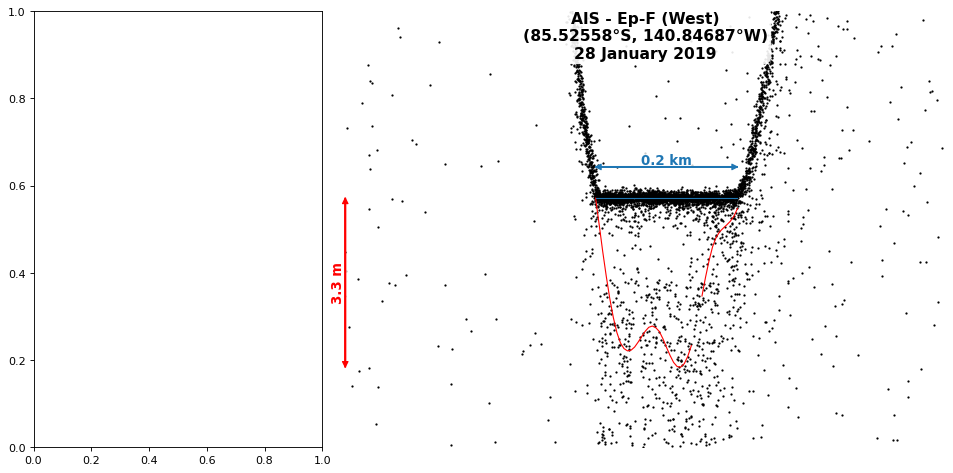

In [56]:
from shapely.geometry import Point

thisplot = 'ant'
ax = ax2 if thisplot=='ant' else ax1
thisgdf = gdf_ant if thisplot=='ant' else gdf_gre
xl = ax.get_xlim()
yl = ax.get_ylim()
thislk = thisgdf[
    (thisgdf.x>xl[0]) &
    (thisgdf.x<xl[1]) &
    (thisgdf.y>yl[0]) &
    (thisgdf.y<yl[1])  
].copy()
thislk.sort_values(by='quality_summary', ascending=False, inplace=True)


# region = 'SE'
# thislk = gdf_gre[gdf_gre.region==region].copy().sort_values(by='quality_summary', ascending=False)
# thislk = gdf_lakes.sort_values(by=['length_water_surfaces', 'max_depth'], ascending=False).copy()
# print('%i lakes in this region\n' % len(thislk))

settings = {
    're_download': True,
    'img_aspect': 1.65,
    'days_buffer': 10,
    'max_cloud_prob': 15,
}

start = 0
length = 20
for i in range(start, np.min((len(thislk),start+length))):

    random1 = {
        'name': None,
        'gamma_value': 0.3,
        'xlm': [None, None],
        'ylm': [None, None],
    }

    fn = thislk.file_name.iloc[i]
    random1['fn'] = fn
    print('%i -----------------------------------------------------' % (i+1))
    print('\n', fn.split('/')[-1], sep='')
    lk = dictobj(read_melt_lake_h5(fn))
    print('latlon = (%.7f, %.7f)' % (lk.lat, lk.lon))
    
    pt = gpd.GeoDataFrame(geometry=[Point(lk.lon, lk.lat)], crs='EPSG:4326').to_crs(gre_gdf_basin.crs).loc[0].geometry
    thisbasin = gre_gdf_basin[gre_gdf_basin.apply(lambda x: pt.within(x.geometry), axis=1)]
    if len(thisbasin) > 0:
        print('Region: ', thisbasin.SUBREGION1.iloc[0])
        print('Basin: ', thisbasin.NAME.iloc[0].lower())
    
    lon_c, lat_c, fig = plot_IS2_imagery(**random1, **settings, return_fig=True)
    display(fig)

2 lakes in this region

1 -----------------------------------------------------

lake_09999991_AIS_2018-19_simplified_ANT_1000_East_C-Cp_ATL03_20190223152044_08730210_006_02_gt3l_0002.h5
-67.6453035947809 82.7054823642265


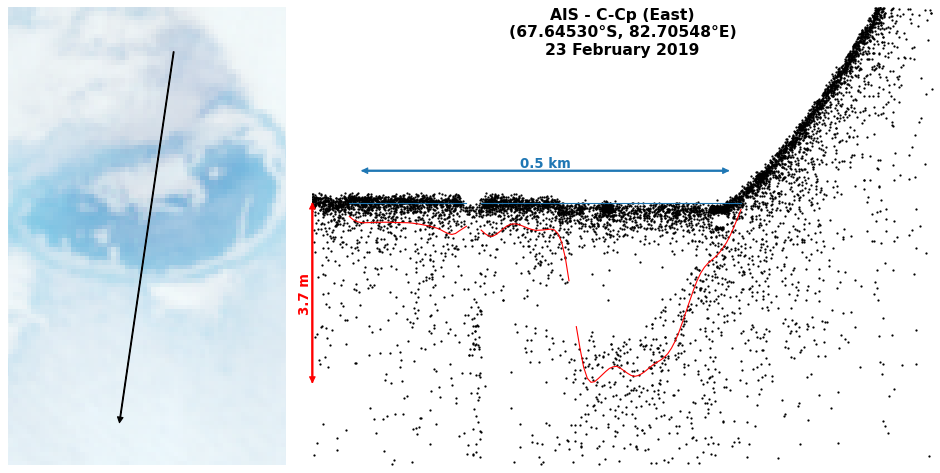

2 -----------------------------------------------------

lake_09999999_AIS_2018-19_simplified_ANT_1000_East_C-Cp_ATL03_20190223152044_08730210_006_02_gt3r_0003.h5
-67.64400213828509 82.7034628758865


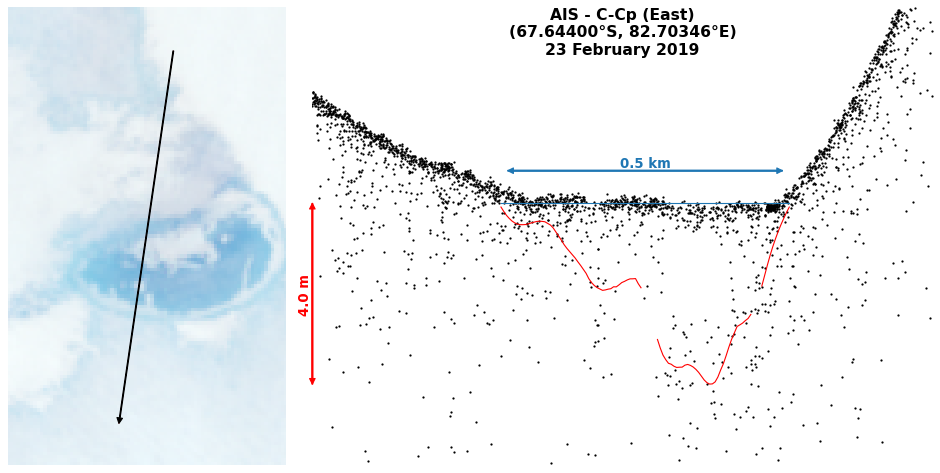

In [170]:
thisplot = 'ant'
ax = ax2 if thisplot=='ant' else ax1
thisgdf = gdf_ant if thisplot=='ant' else gdf_gre
xl = ax.get_xlim()
yl = ax.get_ylim()
thislk = thisgdf[
    (thisgdf.x>xl[0]) &
    (thisgdf.x<xl[1]) &
    (thisgdf.y>yl[0]) &
    (thisgdf.y<yl[1])  
].copy()
thislk.sort_values(by='quality_summary', ascending=False, inplace=True)
thislk.head()

# gran = '_02061411_'
# thislk = thislk[thislk.apply(lambda x: gran in x.granule_id, axis=1)]

# thislk = thislk[np.abs(thislk.surface_elevation) < 20]
print('%i lakes in this region\n' % len(thislk))

settings = {
    're_download': False,
    'img_aspect': 1.65,
    'days_buffer': 365,
    'max_cloud_prob': 30,
}

start = 0
length = 20
for i in range(start, np.min((len(thislk),start+length))):

    random1 = {
        'name': None,
        'gamma_value': 0.7,
        'xlm': [None, None],
        'ylm': [None, None],
    }

    fn = thislk.file_name.iloc[i]
    random1['fn'] = fn
    print('%i -----------------------------------------------------' % (i+1))
    print('\n', fn.split('/')[-1], sep='')
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    
    lon_c, lat_c, fig = plot_IS2_imagery(**random1, **settings, return_fig=True)
    display(fig)

In [ ]:
display(fig)

In [23]:
import ee
import requests
from datetime import datetime 
from datetime import timedelta
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"

#####################################################################
def get_sentinel2_cloud_collection(area_of_interest, date_time, days_buffer):

    datetime_requested = datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%SZ')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    print('Looking for Sentinel-2 images from %s to %s' % (start_date, end_date), end=' ')

    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection,
        'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))

    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))

    cloud_collection = cloud_collection.map(set_is2_cloudiness)

    return cloud_collection

    
#####################################################################
def download_imagery(fn, lk, gt, imagery_filename, days_buffer=5, max_cloud_prob=15, gamma_value=1.8, buffer_factor=1.2):

    # get the bounding box
    lon_rng = gt.lon.max() - gt.lon.min()
    lat_rng = gt.lat.max() - gt.lat.min()
    fac = 0.25
    bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    roi = ee.Geometry.Polygon(poly)

    # get the earth engine collection
    collection_size = 0
    if days_buffer > 200:
        days_buffer = 200
    increment_days = days_buffer
    while (collection_size<5) & (days_buffer <= 200):
    
        collection = get_sentinel2_cloud_collection(area_of_interest=roi, date_time=lk.date_time, days_buffer=days_buffer)
    
        # filter collection to only images that are (mostly) cloud-free along the ICESat-2 ground track
        cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_prob))
        
        collection_size = cloudfree_collection.size().getInfo()
        if collection_size == 1: 
            print('--> there is %i cloud-free image.' % collection_size)
        elif collection_size > 1: 
            print('--> there are %i cloud-free images.' % collection_size)
        else:
            print('--> there are not enough cloud-free images: widening date range...')
        days_buffer += increment_days
    
        # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
        is2time = lk.date_time
        def set_time_difference(img, is2time=is2time):
            timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
            return img.set('timediff', timediff)
        cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

    # create a region around the ground track over which to download data
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    gt_length = gt.x10.max() - gt.x10.min()
    point_of_interest = ee.Geometry.Point(lon_center, lat_center)
    region_of_interest = point_of_interest.buffer(gt_length*0.5*buffer_factor)

    if collection_size > 0:
        # select the first image, and turn the colleciton into an 8-bit RGB for download
        selectedImage = cloudfree_collection.first()
        mosaic = cloudfree_collection.sort('timediff', False).mosaic()
        rgb = mosaic.select('B4', 'B3', 'B2')
        rgb = rgb.unitScale(0, 10000).clamp(0.0, 1.0)
        rgb_gamma = rgb.pow(1/gamma_value)
        rgb8bit= rgb_gamma.multiply(255).uint8()
        
        # from the selected image get some stats: product id, cloud probability and time difference from icesat-2
        prod_id = selectedImage.get('PRODUCT_ID').getInfo()
        cld_prb = selectedImage.get('ground_track_cloud_prob').getInfo()
        s2datetime = datetime.fromtimestamp(selectedImage.get('system:time_start').getInfo()/1e3)
        s2datestr = datetime.strftime(s2datetime, '%Y-%b-%d')
        is2datetime = datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ')
        timediff = s2datetime - is2datetime
        days_diff = timediff.days
        if days_diff == 0: diff_str = 'Same day as'
        if days_diff == 1: diff_str = '1 day after'
        if days_diff == -1: diff_str = '1 day before'
        if days_diff > 1: diff_str = '%i days after' % np.abs(days_diff)
        if days_diff < -1: diff_str = '%i days before' % np.abs(days_diff)
        
        print('--> Closest cloud-free Sentinel-2 image:')
        print('    - product_id: %s' % prod_id)
        print('    - time difference: %s' % timediff)
        print('    - mean cloud probability: %.1f' % cld_prb)
        
        # get the download URL and download the selected image
        success = False
        scale = 10
        tries = 0
        while (success == False) & (tries <= 7):
            try:
                downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                                          'crs': selectedImage.select('B3').projection().crs(),
                                                          'scale': scale,
                                                          'region': region_of_interest,
                                                          'filePerBand': False,
                                                          'format': 'GEO_TIFF'})
        
                response = requests.get(downloadURL)
                with open(imagery_filename, 'wb') as f:
                    f.write(response.content)
        
                print('--> Downloaded the 8-bit RGB image as %s.' % imagery_filename)
                success = True
                tries += 1
            except:
                traceback.print_exc()
                scale *= 2
                print('-> download unsuccessful, increasing scale to %.1f...' % scale)
                success = False
                tries += 1

    # else:
    #     fac = 1.5
    #     bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    #     poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    #     roi = ee.Geometry.Polygon(poly)
    #     s2_sr_collection = (ee.ImageCollection("MODIS/061/MOD09GQ"))
    #     .filterBounds(area_of_interest)
    #     .filterDate(start_date, end_date))
            
#####################################################################
def plot_imagery(fn, days_buffer=5, max_cloud_prob=15, xlm=[None, None], ylm=[None, None], gamma_value=1.8, imagery_filename=None,
                 re_download=True, ax=None, buffer_factor=1.2):
                     
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+lk.max_depth
    if not imagery_filename:
        imagery_filename = 'imagery' + fn[fn.rfind('/'):].replace('.h5','.tif')
    
    
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    
    dfd = lk.depth_data.copy()
    dfd.xatc -= x_off

    # get the ground track
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    
    if (not os.path.isfile(imagery_filename)) or re_download or ('modis' in imagery_filename):
        download_imagery(fn=fn, lk=lk, gt=gt, imagery_filename=imagery_filename, days_buffer=days_buffer, 
                         max_cloud_prob=max_cloud_prob, gamma_value=gamma_value, buffer_factor=buffer_factor)
    
    try:
        myImage = rio.open(imagery_filename)
        
        # make the figure
        if not ax:
            fig, ax = plt.subplots(figsize=[6,6])
        
        rioplot.show(myImage, ax=ax)
        ax.axis('off')
        # add_graticule(img=myImage, ax_img=ax)
        
        # add some info about the Sentinel-2 image
        # txt = '%s' % lk.date_time[:10]
        # ax.text(0.0, -0.01, txt, transform=ax.transAxes, ha='left', va='top',fontsize=6)
    
        ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=np.array(gt.lon), ys=np.array(gt.lat))
        ax.annotate('', xy=(ximg[-1], yimg[-1]), xytext=(ximg[0], yimg[0]),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='k'),zorder=1000)
        ax.plot(ximg, yimg, 'r-', lw=0.5, zorder=500)
        
        if not ax:
            fig.tight_layout(pad=0)
    
        return myImage, lon_center, lat_center
    except: 
        return None, lon_center, lat_center

                     
#####################################################################
def plotIS2(fn, ax=None, xlm=[None, None], ylm=[None,None], cmap=cmc.lapaz_r, name='ICESat-2 data'):
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+1.5*lk.max_depth
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    dfd = dfd[(dfd.xatc >= xlm[0]) & (dfd.xatc <= xlm[1]) & (dfd.h_fit_bed >= ylm[0])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd.xatc -= x_off
    

    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    surf_only = surf[~np.isnan(surf)]
    bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
    xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
    xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
    
    # make the figure
    if not ax:
        fig, ax = plt.subplots(figsize=[8,5])
    if not cmap:
        ax.scatter(df.xatc, df.h, s=1, c='k')
    else:
        ax.scatter(df.xatc, df.h, s=1, c=df.snr, cmap=cmap)
        
    # ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=4, color='r', alpha=dfd.conf[isdepth])
    # ax.plot(dfd.xatc, dfd.h_fit_bed, color='gray', lw=0.5)
    ax.plot(dfd.xatc, bed, color='r', lw=1)
    ax.plot(dfd.xatc, surf, color='C0', lw=1)

    # add the length of surface
    arr_y = lk.surface_elevation+lk.max_depth*0.25
    x_start = np.min(xatc_surf)
    x_end = np.max(xatc_surf)
    x_mid = (x_end + x_start) / 2
    len_surf_m = np.floor((x_end-x_start)/100)*100
    len_surf_km = len_surf_m/1000
    arr_x1 = x_mid - len_surf_m / 2
    arr_x2 = x_mid + len_surf_m / 2
    ax.annotate('', xy=(arr_x1, arr_y), xytext=(arr_x2, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.annotate('', xy=(arr_x2, arr_y), xytext=(arr_x1, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.text(x_mid, arr_y, '%.1f km' % len_surf_km, fontsize=12, ha='center', va='bottom', color='C0', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

    # add the max depth
    y_low = np.min(bed_only)
    y_up = lk.surface_elevation
    arr_x = xatc_bed[np.argmin(bed_only)]
    arr_x = xlm[0] - 0.0* (xlm[1] - xlm[0])
    y_len = y_up - y_low
    y_mid = (y_up + y_low) / 2
    arr_len = y_len
    arr_y1 = y_mid + arr_len / 2
    arr_y2 = y_mid - arr_len / 2
    ref_index = 1.33
    dep_round = np.round(y_len / ref_index, 1)
    ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.text(arr_x, y_mid, '%.1f m' % dep_round, fontsize=12, ha='right', va='center', color='r', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)

    # add the title
    datestr = datetime.strftime(datetime.strptime(lk.date_time[:10],'%Y-%m-%d'), '%d %B %Y')
    if not name:
        sheet = lk.ice_sheet
        region = lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        if sheet == 'AIS':
            region = region + ' (%s)' % lk.polygon_filename.split('_')[-2]
        latstr = lk.lat_str[:-1] + '°' + lk.lat_str[-1]
        lonstr = lk.lon_str[:-1] + '°' + lk.lon_str[-1]
        name = '%s - %s\n(%s, %s)' % (sheet, region, latstr, lonstr)
    
    ax.text(0.5, 1.0, '%s\n%s' % (name, datestr), fontsize=14, ha='center', va='top', transform=ax.transAxes,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), fontweight='bold')
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    ax.axis('off')

    
#####################################################################
def plot_IS2_imagery(fn, axes=None, xlm=[None,None], ylm=[None,None], cmap=None, days_buffer=5, max_cloud_prob=15, 
                     gamma_value=1.8, imagery_filename=None, re_download=True, img_aspect=3/2, name='ICESat-2 data',
                     return_fig=False):

    if not axes:
        fig = plt.figure(figsize=[12,6], dpi=80)
        gs = fig.add_gridspec(1,3)
        axp = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]
    else:
        axp = axes
        
    ax = axp[1]
    plotIS2(fn=fn, ax=ax, xlm=xlm, ylm=ylm, cmap=cmap, name=name)
    
    ax = axp[0]
    img, center_lon, center_lat = plot_imagery(fn=fn, days_buffer=days_buffer, max_cloud_prob=max_cloud_prob, xlm=xlm, ylm=ylm, 
        gamma_value=gamma_value, imagery_filename=imagery_filename, re_download=re_download, ax=ax)
                         
    if img:                     
        if img_aspect > 1: 
            h_rng = img.bounds.top - img.bounds.bottom
            cntr = (img.bounds.right + img.bounds.left) / 2
            ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
        if img_aspect < 1: 
            w_rng = img.bounds.right - img.bounds.left
            cntr = (img.bounds.top + img.bounds.bottom) / 2
            ax.set_xlim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
    
    if not axes:
        fig.tight_layout(pad=1, h_pad=0, w_pad=0)
        if not name:
            name = 'zzz' + lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        outname = 'figplots/' + name.replace(' ', '') + fn[fn.rfind('/')+1:].replace('.h5','.jpg')
        fig.savefig(outname, dpi=300)

    if return_fig:
        plt.close(fig)
        return center_lon, center_lat, fig
    else:
        return center_lon, center_lat

In [ ]:


settings = {
    're_download': True,
    'img_aspect': 1.65,
    'days_buffer': 5,
    'max_cloud_prob': 15,
}

amery = {
    'name': 'Amery Ice Shelf',
    'fn': '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09981513_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190221161201_08430210_006_02_gt3l_0003.h5',
    'gamma_value': 0.3,
    'xlm': [None, None],
    'ylm': [None, None],
}

shackleton = {
    'name': 'Shackleton Ice Shelf',
    'fn': '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09948894_AIS_2019-20_simplified_ANT_1000_East_C-Cp_ATL03_20200126220646_04760610_006_01_gt3r_0024.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}
shackleton2 = {
    'name': 'Shackleton Ice Shelf',
    'fn': '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09996383_AIS_2019-20_simplified_ANT_1000_East_C-Cp_ATL03_20200224204246_09180610_006_01_gt2r_0002.h5',
    'gamma_value': 0.5,
    'xlm': [None, None],
    'ylm': [None, None],
}

tucker = {
    'name': 'Tucker Glacier',
    'fn': '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09990783_AIS_2020-21_simplified_ANT_1000_East_Dp-E_ATL03_20210128124234_05421012_006_01_gt3r_0001.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

# from here on new data
bench_lake = {
    'name': 'An ice shelf bench!',
    'fn': '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09736217_AIS_2019-20_simplified_ANT_1000_East_Dp-E_ATL03_20200101075253_00850612_006_01_gt1r_0000.h5',
    'gamma_value': 5.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

######################################################
# from here on new data

settings = {
    're_download': True,
    'img_aspect': 1.65,
    'days_buffer': 10,
    'max_cloud_prob': 20,
}


cpath = r"""

"C:\Users\phili\Documents\IceLakesRun2\GlacierLakeDetectionICESat2\lakes_interesting_cases\lake_09990344_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20181229185130_00200210_006_02_gt3r_0071.h5"

"""

plt.close('all')
base_path = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/'
pth = cpath
filename = pth[pth.rfind("\\")+1:pth.find('.h5')+3]
fn = base_path+filename

random1 = {
    'name': ' ',
    'fn': fn,
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}


plot_IS2_imagery(**random1, **settings)
# plot_IS2_imagery(**shackleton2, **settings)
# plot_IS2_imagery(**amery, **settings)
# plot_IS2_imagery(**tucker, **settings)

In [ ]:
# fn = shackleton2['fn']
# thislk = dictobj(read_melt_lake_h5(fn))
# thislk.plot_lake()

In [ ]:
gre_bound = gre_gdf_basin.dissolve().simplify(10000).boundary
ant_bound = ant_gdf_basin.dissolve().simplify(10000).boundary

In [ ]:
def plot_coords(coords, ax, crs_dst, crs_src='EPSG:4326', text=None, color='r', ms=10, fs=16):
    coords_trans = warp.transform(src_crs=crs_src, dst_crs=crs_dst, xs=[coords[0]], ys=[coords[1]])
    x = coords_trans[0][0]
    y = coords_trans[1][0]
    if not text:
        ax.scatter(x, y, coords_trans[1][0], s=ms, color=color)
    else:
        ax.text(x, y, text, fontsize=fs, color='k', ha='center', va='center',
                bbox=dict(facecolor=color, alpha=1, boxstyle='round,pad=0.3,rounding_size=1', lw=0))

In [ ]:
##########################################
# CREATE FIGURE AND AXES
fig = plt.figure(figsize=[32,16], dpi=30)
gs = fig.add_gridspec(6, 18)
axs = []
axs.append(fig.add_subplot(gs[1:5, 3:6])) # greenland
axs.append(fig.add_subplot(gs[1:5, 9:15])) # antarctica
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[0, j]))
    axs.append(fig.add_subplot(gs[0, j+1:j+3]))
for i in range(1,5):
    for j in np.array([0, 2, 5])*3:
        axs.append(fig.add_subplot(gs[i, j]))
        axs.append(fig.add_subplot(gs[i, j+1:j+3]))
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[5, j]))
    axs.append(fig.add_subplot(gs[5, j+1:j+3]))

# get region counts
df_lakes['region'] = df_lakes.apply(lambda x: x.basin.split('_')[-1], axis=1)
region_counts = df_lakes.groupby(by='region')['lake_id'].count().to_dict()

##########################################
# GREENLAND MAP
ax = axs[0]
gre_bound.plot(color='k', ax=ax, lw=0.5)
gre_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
# show basin labels and lake counts
for i in range(len(gre_gdf_merged)):
    x = gre_gdf_merged.iloc[i]
    region = x.SUBREGION1
    lake_count = region_counts[region] if region in region_counts.keys() else 0
    ax.annotate(text='%s' % region, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                       color='k',fontsize=14, weight='bold')
    ax.annotate(text='%i lakes' % lake_count, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                       color='k',fontsize=12)
    
# gdf_gre.sort_values(by='quality_summary', inplace=True)
# code to scatter lake points here
ax.axis('off')

##########################################
# ANTARCTICA MAP
ax = axs[1]

ant_gdf_merged.exterior.plot(color='gray', ax=ax, lw=0.3)
ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0)
ant_bound.plot(color='k', ax=ax, lw=0.5)
ant_gdf_shelf.boundary.plot(color='k', ax=ax, lw=0.5)

# show basin labels and lake counts
for i in range(len(ant_gdf_merged)):
    x = ant_gdf_merged.iloc[i]
    region = x.Subregions
    lake_count = region_counts[region] if region in region_counts.keys() else 0
    thename = '%s' % region
    thecount = '%i lakes' % lake_count
    if region in ant_region_locs.keys():
        locs = ant_region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color='k',fontsize=14, weight='bold')
        ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color='k',fontsize=12)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = 0.1
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='top',color='k',fontsize=12,
                         arrowprops=dict(width=1, headwidth=7, headlength=7, color='k'),zorder=1000)
        else:
            ax.annotate(text=thecount, xy=xytext, ha='center',va='top',color='k',fontsize=12)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                           color='k',fontsize=14, weight='bold')
        ax.annotate(text=thecount, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                           color='k',fontsize=12)
    
# gdf_ant.sort_values(by='quality_summary', inplace=True)
# code to scatter lake points here
ax.axis('off')

##########################################
# LAKE PLOTS (ICESat-2 and imagery)
settings = {
    're_download': False,  # to avoid, re-downloading scenes that were already acquired
    'img_aspect': 1.65  # adjust to fill max space in the figure
}

# Antarctica
ax_map = axs[1] 
coords = plot_IS2_imagery(**amery, axes=axs[30:32], **settings)
plot_coords(coords, ax=ax_map, crs_dst=ant_bound.crs, text='a')
coords = plot_IS2_imagery(**shackleton, axes=axs[36:38], **settings)
plot_coords(coords, ax=ax_map, crs_dst=ant_bound.crs, text='b')
coords = plot_IS2_imagery(**tucker, axes=axs[46:48], **settings)
plot_coords(coords, ax=ax_map, crs_dst=ant_bound.crs, text='c')

# remove tick marks
for i in range(len(axs)):
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])

# plot axes indices for the time being 
for i, ax in enumerate(axs):
    ax.text(0.5, 0.5, '%i'%i, ha='center', va='center', transform=ax.transAxes, fontsize=14)

fig.tight_layout(pad=0.3, h_pad=0.5, w_pad=0.8)

# to get coordinates from clicks
coords = []
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("'x': %.3f, 'y': %.3f" % (ix,iy))

    global coords
    coords = (ix,iy)
    
    if len(coords) > 3:
        fig.canvas.mpl_disconnect(cid)

    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)

fig.savefig('zzzzzbigplot.jpg', dpi=600)

# TODO:
# - get better locations for region labels and lake counts (some with arrow)
# - add scatter points for lake locations
# - add legend
# - make the arrow over imagery red where there is water?
# - make it easier to adjust font sizes?
# - arrows from ICESat-2/imagery plots to their location on the maps?
# - add lat/lon to ICESat-2 plots?

In [ ]:
region = 'I-Ipp'
print("'%s': {'x': %.3f, 'y': %.3f}," % (region, coords[0], coords[1]))
print(", 'x_arr': %.3f, 'y_arr': %.3f" % (coords[0], coords[1]))

In [ ]:
ant_region_locs = {
    'B-C': {'x': 1351942.498, 'y': 547965.466},
    'I-Ipp': {'x': -2194009.602, 'y': 1902303.964, 'x_arr': -2432856.117, 'y_arr': 1238258.100},
}

In [ ]:
# get the counts of lakes per region
df_lakes['region'] = df_lakes.apply(lambda x: x.basin.split('_')[-1], axis=1)
region_counts = df_lakes.groupby(by='region')['lake_id'].count().to_dict()
region_counts

In [ ]:
coords
crs_dst = ant_bound.crs
crs_src='EPSG:4326'
coords_trans = warp.transform(src_crs=crs_src, dst_crs=crs_dst, xs=[coords[0]], ys=[coords[1]])
coords_trans

In [ ]:
np.array([48,24]) * 2/3

In [ ]:
fig = plt.figure(figsize=[32,16], dpi=30)
gs = fig.add_gridspec(6, 18)
axs = []
axs.append(fig.add_subplot(gs[1:5, 3:6])) # greenland
axs.append(fig.add_subplot(gs[1:5, 9:15])) # antarctica
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[0, j]))
    axs.append(fig.add_subplot(gs[0, j+1:j+3]))
for i in range(1,5):
    for j in np.array([0, 2, 5])*3:
        axs.append(fig.add_subplot(gs[i, j]))
        axs.append(fig.add_subplot(gs[i, j+1:j+3]))
for j in range(0, 18, 3):
    axs.append(fig.add_subplot(gs[5, j]))
    axs.append(fig.add_subplot(gs[5, j+1:j+3]))

# ax = axs[0]
# gre_gdf_basin.dissolve().simplify(1000).boundary.plot(color='gray', ax=ax, lw=0.2)
# ax.axis('off')

# ax = axs[1]
# ant_gdf_basin.dissolve().simplify(1000).boundary.plot(color='gray', ax=ax, lw=0.2)
# ax.axis('off')

settings = {
    're_download': False
}

plot_IS2_imagery(**amery, axes=axs[30:32], **settings)
    
# for ax in axs:
#     ax.xaxis.set_ticks([])
#     ax.yaxis.set_ticks([])

fig.tight_layout(pad=0, h_pad=0, w_pad=0)

for i, ax in enumerate(axs):
    ax.text(0.5, 0.5, '%i'%i, ha='center', va='center', transform=ax.transAxes, fontsize=20)

fig.tight_layout(pad=1, h_pad=1, w_pad=1)

In [ ]:
for i in range(0,11,2):
    print(i)

In [ ]:
# shackleton, ~400m of bench along-track
/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09928792_AIS_2020-21_simplified_ANT_1000_East_C-Cp_ATL03_20201118081610_08420910_006_01_gt2l_0000.h5
quality summary: 0.7120763946 | detection_quality: 0.1429222 | lake_quality: 4.88192
plotIS2S2(lon=95.5282163, 
          lat=-65.6302772, 
          date='2020-11-18',
          rgt=842, 
          gtx='gt2l', 
          buffer_m=1000, 
          max_cloud_prob=15, 
          gamma_value=3.0, 
          plot_filename='plots/bench_test.jpg'
          )

# drygalski ice tongue, nice rampart-moat (half of shelf freeboard, 20m), ~100m of bench 
/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_09934801_AIS_2019-20_simplified_ANT_1000_East_Dp-E_ATL03_20200101075253_00850612_006_01_gt1r_0000.h5
quality summary: 0.6519904661 | detection_quality: 0.1040681 | lake_quality: 6.16443
plotIS2S2(lon=164.7199980, 
          lat=-75.3612364, 
          date='2020-01-01',
          rgt=85, 
          gtx='gt1r', 
          buffer_m=1000, 
          max_cloud_prob=15, 
          gamma_value=3.0, 
          plot_filename='plots/bench_test.jpg'
          )

# shackleton, very strong bench signal (~150m along-track)
/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/detection_out_data/lake_10000000_AIS_2019-20_simplified_ANT_1000_East_C-Cp_ATL03_20191204133404_10480512_006_01_gt1r_0000.h5
quality summary: 0.0000000000 | detection_quality: 0.0000000 | lake_quality: 0.00000
plotIS2S2(lon=95.5029707, 
          lat=-65.8131674, 
          date='2019-12-04',
          rgt=1048, 
          gtx='gt1r', 
          buffer_m=1000, 
          max_cloud_prob=15, 
          gamma_value=3.0, 
          plot_filename='plots/bench_test.jpg'
          )

In [ ]:
thisplot = 'ant'
ax = ax2 if thisplot=='ant' else ax1
thisgdf = gdf_ant if thisplot=='ant' else gdf_gre
xl = ax.get_xlim()
yl = ax.get_ylim()
thislk = thisgdf[
    (thisgdf.x>xl[0]) &
    (thisgdf.x<xl[1]) &
    (thisgdf.y>yl[0]) &
    (thisgdf.y<yl[1])  
].copy()
thislk.sort_values(by='quality_summary', ascending=False, inplace=True)
thislk.head()

# thislk = thislk[np.abs(thislk.surface_elevation) < 20]
print(len(thislk))

for i in range(np.min((len(thislk),10))):
    fn = thislk.file_name.iloc[i]
    print(fn)
    lk = dictobj(read_melt_lake_h5(fn))
    qual_sum = lk.quality_summary
    print('quality summary: %.10f | detection_quality: %.7f | lake_quality: %.5f' % (qual_sum, lk.detection_quality, lk.lake_quality))
    fig, ax = plt.subplots(figsize=[9,5])
    ax.scatter(lk.photon_data.xatc, lk.photon_data.h, s=1, c='k')
    isdepth = lk.depth_data.depth>0
    #ax.scatter(lk.depth_data.xatc[isdepth], lk.depth_data.h_fit_bed[isdepth], s=4, color='r', alpha=lk.depth_data.conf[isdepth])
    bed = lk.depth_data.h_fit_bed
    bed[~isdepth] = np.nan
    #ax.plot(lk.depth_data.xatc, lk.depth_data.h_fit_bed, color='gray', lw=0.5)
    surf = np.ones_like(lk.depth_data.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    #ax.plot(lk.depth_data.xatc, surf, color='C0', lw=0.8)
    rng = lk.surface_elevation - np.min(lk.depth_data.h_fit_bed[isdepth])
    ax.set_ylim((lk.depth_data.h_fit_bed[isdepth].min()-rng, lk.surface_elevation+rng))
    # ax.set_ylim(-50, 40)

    string = '''plotIS2S2(lon=%.7f, 
          lat=%.7f, 
          date='%s',
          rgt=%i, 
          gtx='%s', 
          buffer_m=1000, 
          max_cloud_prob=15, 
          gamma_value=3.0, 
          plot_filename='plots/bench_test.jpg'
          )''' % (lk.lon, lk.lat, lk.date_time[:10], lk.rgt, lk.gtx)
    # print(string)

In [ ]:
lk.date_time[:10]

In [ ]:
vars(lk).keys()